In [70]:
import pandas as pd
import plotly.express as px
from typing import List
from IPython.display import display, HTML, Image

In [71]:
data = pd.read_csv('data/TOGG T10X Kullanıcı Anketi.csv')
mapping = {
    'ocak': '01',
    'şubat': '02',
    'mart': '03',
    'nisan': '04',
    'mayıs': '05',
    'haziran': '06',
    'temmuz': '07',
    'ağustos': '08',
    'eylül': '09',
    'ekim': '10',
    'kasım': '11',
    'aralık': '12'
}
mapping_q = {
    'ocak': 'Q1',
    'şubat': 'Q1',
    'mart': 'Q1',
    'nisan': 'Q2',
    'mayıs': 'Q2',
    'haziran': 'Q2',
    'temmuz': 'Q3',
    'ağustos': 'Q3',
    'eylül': 'Q3',
    'ekim': 'Q4',
    'kasım': 'Q4',
    'aralık': 'Q4'
}
data['Yıl-Ay'] = data['Yıl'].astype('str') + '-' + data['Ay'].map(mapping)
data['Dönem'] = data['Yıl'].astype('str') + '-' + data['Ay'].map(mapping_q)
data.drop(columns=['Timestamp', 'Ay'], inplace=True)
TotalRespondents = len(data.index)

In [72]:
def get_question(idx: int) -> str:
    return data.columns[idx]

In [73]:
def get_perc_stats(col:str, facet:str=None, top_n=0, filter=None):
    groupby = [facet, col] if facet is not None else col
    if filter is None:
        _data = data.copy()
    else:
        _filter = pd.Series(True, index=data.index)
        for k, v in filter.items():
            _filter &= (data[k] == v)
        _data = data.loc[_filter].copy()
    x = _data.groupby(groupby).aggregate(Count=(col, 'count')).reset_index().rename(columns={col:'Response'})
    
    if top_n > 0:
        grouped = x.set_index('Response').sort_values(by='Count', ascending=False)
        top = grouped.iloc[:top_n]
        others = grouped.iloc[top_n:].sum().to_frame().T
        others.index = ['Diğer']
        x = pd.concat([top, others]).reset_index().rename(columns={'index':'Response'})
    
    if facet:
        total = x.groupby(facet)['Count'].transform('sum')
    else:
        total = x['Count'].sum()
    x['Percentage'] = (x['Count'] / total).map(lambda v: f"{v*100:.1f}%")
    
    if pd.api.types.is_string_dtype(x['Response']):
        max_len = x['Response'].str.len().max()
        x['Response'] = x['Response'].str.ljust(max_len, ' ')
    return x

In [74]:

def make_chart(question:int|str, horizontal=False, top_n=0, sort_values=False, rating=False, facet=None, filter=None):
    if isinstance(question, int):
        question = get_question(question)
    
    df = get_perc_stats(question, facet=facet, top_n=top_n, filter=filter)
    title = question
    if filter is not None:
        _txt_filter = ' | '.join(f'{k}: {v}' for k, v in filter.items())
        title += '<br>' + _txt_filter
            
    if rating:
        options = [x for x in range(1, 11)]
        zeroes = [response for response in options if response not in df['Response'].values]
        missing_df = pd.DataFrame({
            'Response': zeroes,
            'Count': 0,
            'Percentage': '0.0%'
        })
        df = pd.concat([df, missing_df], ignore_index=True)
        df = df.set_index('Response').loc[options].reset_index()

        count = df['Count'].sum()
        total = (df['Count'] * df['Response']).sum()


        above8 = df.loc[df['Response'].isin([8, 9, 10]), 'Count'].sum()
        average = total / count

        title=f'{question}<br>Ortalama: {average:.1f} | 8+: {above8/count*100:.1f}%'

    font_family = "Fira Mono, Consolas, Courier New, monospace"
    white = '#e9e9e9'
    bgcolor = '#3b4045'

    if horizontal:
        if facet:
            fig = px.bar(
                df,
                x='Response',
                y='Count',
                text='Percentage',
                facet_col=facet,
            )

            fig.update_traces(textposition='outside')
            fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
            for annotation in fig.layout.annotations:
                annotation.font.color = white
                # annotation.font.size = 14
                # annotation.font.family = "Arial"    
            for key in fig.layout:
                if key.startswith("xaxis") or key.startswith("yaxis"):
                    fig.layout[key].tickfont = dict(family=font_family, color=white)
                    fig.layout[key].linecolor = bgcolor
                    fig.layout[key].showgrid = False
                    fig.layout[key].title=None
                if key.startswith('yaxis'):
                    fig.layout[key].showticklabels = False
        else:
            if sort_values:
                df.sort_values(by='Count', ascending=False, inplace=True)
            fig = px.bar(df, x='Response', y='Count', text='Percentage')
            fig.update_layout(
                yaxis=dict(showticklabels=False, gridcolor=bgcolor),
                xaxis=dict(tickangle=0,type='category'),
            )
        fig.update_traces(width=0.3)
    else:
        if facet:
            fig = px.bar(
                df,
                x='Count',
                y='Response',
                text='Percentage',
                facet_row=facet,
            )

            fig.update_traces(textposition='outside')
            fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
            for annotation in fig.layout.annotations:
                annotation.font.color = white
                # annotation.font.size = 14
                # annotation.font.family = "Arial"    
            for key in fig.layout:
                if key.startswith("xaxis") or key.startswith("yaxis"):
                    fig.layout[key].tickfont = dict(family=font_family, color=white)
                    fig.layout[key].linecolor = bgcolor
                    fig.layout[key].showgrid = False
                    fig.layout[key].title=None
                if key.startswith('yaxis'):
                    fig.layout[key].showticklabels = False
        else:
            if sort_values:
                df.sort_values(by='Count', ascending=True, inplace=True)
            else:
                df = df.iloc[::-1]
            fig = px.bar(df, y='Response', x='Count', text='Percentage', orientation='h')
            fig.update_layout(
                xaxis=dict(showticklabels=False, gridcolor=bgcolor),
                yaxis=dict(type='category'),
            )
        fig.update_traces(width=0.4)

    fig.update_layout(
        xaxis=dict(tickfont=dict(family=font_family, color=white), showgrid=False, linecolor=bgcolor),
        yaxis=dict(tickfont=dict(family=font_family, color=white), showgrid=False, linecolor=bgcolor),
        xaxis_title=None,
        yaxis_title=None,
        plot_bgcolor=bgcolor,
        paper_bgcolor=bgcolor,
        margin=dict(l=10, r=10, t=80, b=80),
        title=title,
        title_font=dict(family=font_family, color=white, weight='bold'),
        hoverlabel=dict(
           bgcolor=white,
            font_size=12,
            font_family=font_family,
        ),
        annotations=[
        dict(
            text=f"Katılımcı: {df['Count'].sum()}",
            showarrow=False,
            xref="paper", yref="paper",
            x=1, y=-0.15,
            xanchor='right', yanchor='top',
            font=dict(size=12, color=white)
        )
        ]
    )
    fig.update_traces(
            texttemplate=' %{text}',
            textposition='outside',
            textfont=dict(
                size=13,
                family="Fira Mono, Consolas, Courier New, monospace",
                color=white,
                weight='bold'
            ),
        marker=dict(
            color='#1c9ef9',
            line=dict(color='rgba(0,0,0,0)', width=0),
        )
        )
    if facet:
        fig.update_layout(plot_bgcolor='#26313c')

    
    # fig.update_traces(marker_line_width=0, width=0.25)
    # fig.update_layout(bargap=0.05) 
    
    # Use this for pdf.
    # return Image(fig.to_image(format="png", width=1720, scale=2))
    return fig

## Kullanıcı Profili

In [75]:
make_chart(0)

In [76]:
make_chart(1, horizontal=False, top_n=5)

In [77]:
for idx in [2, 3, 4, 10, 11]:
    img = make_chart(idx, sort_values=True)
    display(img)

## T10X Profili

In [78]:
# fig = make_chart('Yıl-Ay', sort_values=False, horizontal=True)
# fig.update_layout(xaxis=dict(tickangle=-45))

In [79]:
for idx in [5, 6, 7, 8, 9, 12]:
    top_n = 3 if idx == 7 else 0
    fig = make_chart(idx, sort_values=True, top_n=top_n)
    display(fig)

## Sonraki Aracım

In [80]:
for idx in range(13, 16):
    fig = make_chart(idx, sort_values=True)
    display(fig)

## Şarj Alışkanlığınız

In [81]:
for idx in range(16, 20):
    fig = make_chart(idx, sort_values=True)
    display(fig)

## Memnuniyet Durumu

In [82]:
for idx in [21, 20]:
    fig = make_chart(idx, sort_values=True, horizontal=False, rating=False)
    display(fig)

In [ ]:
for idx in range(22, 32):
    fig = make_chart(idx, sort_values=False, horizontal=True, rating=True)
    display(fig)

## Servis

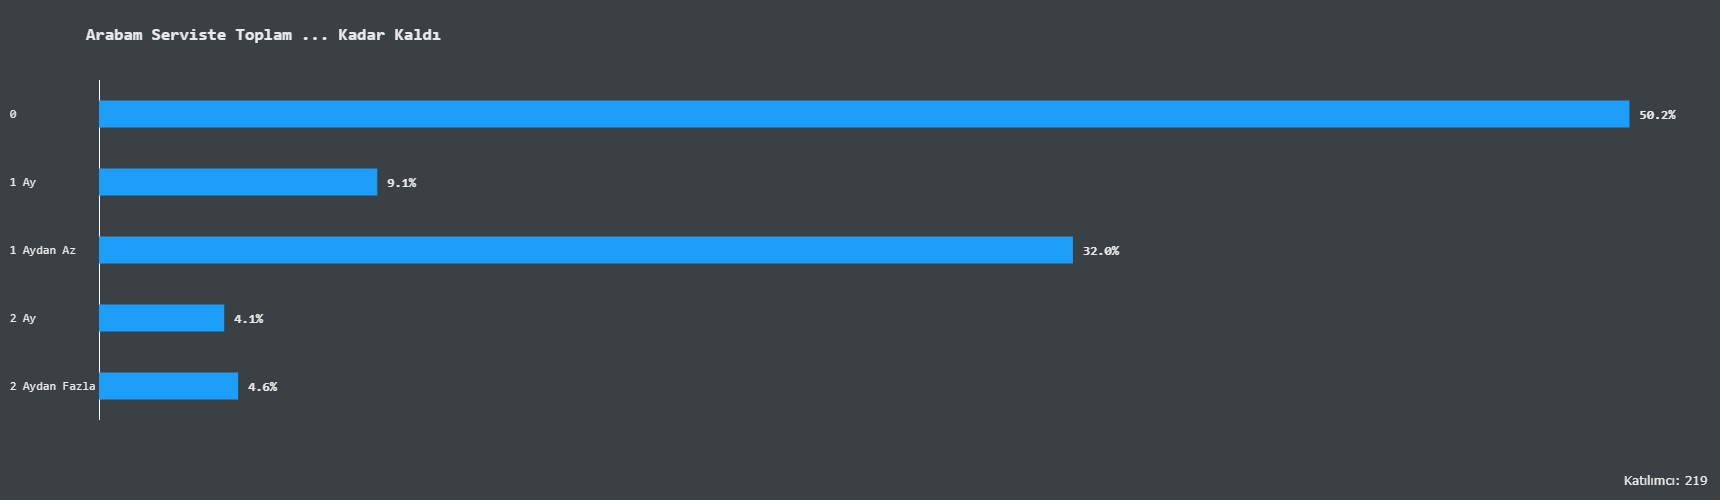

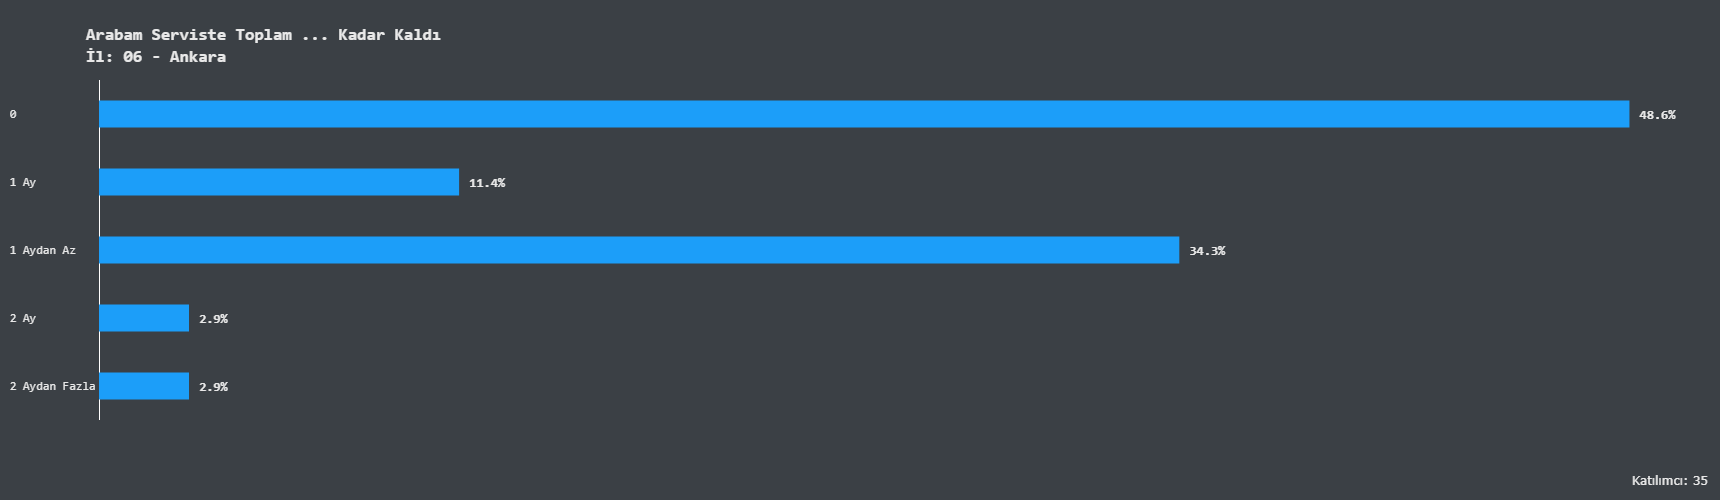

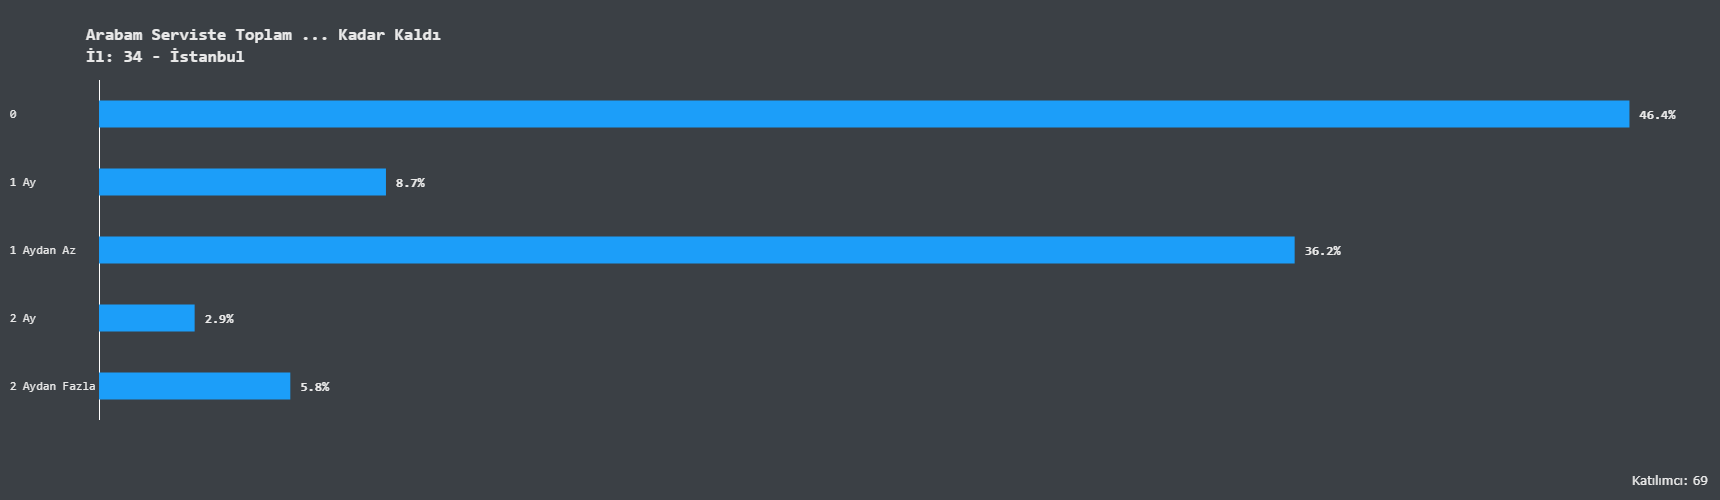

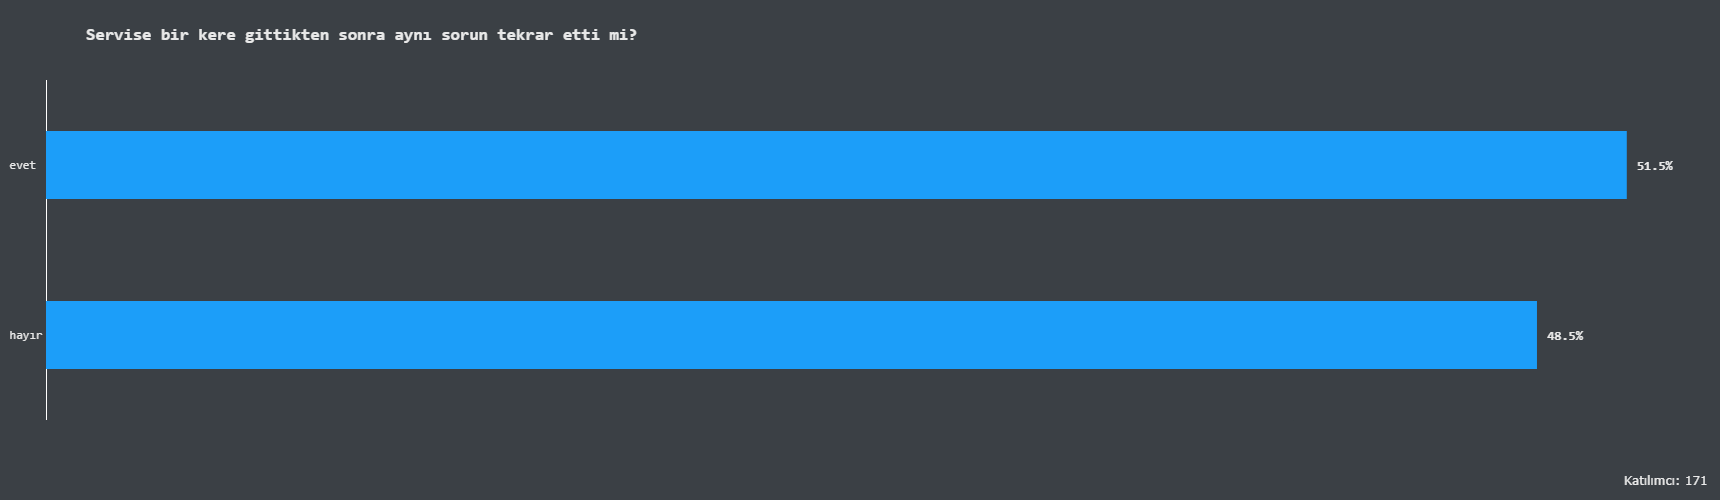

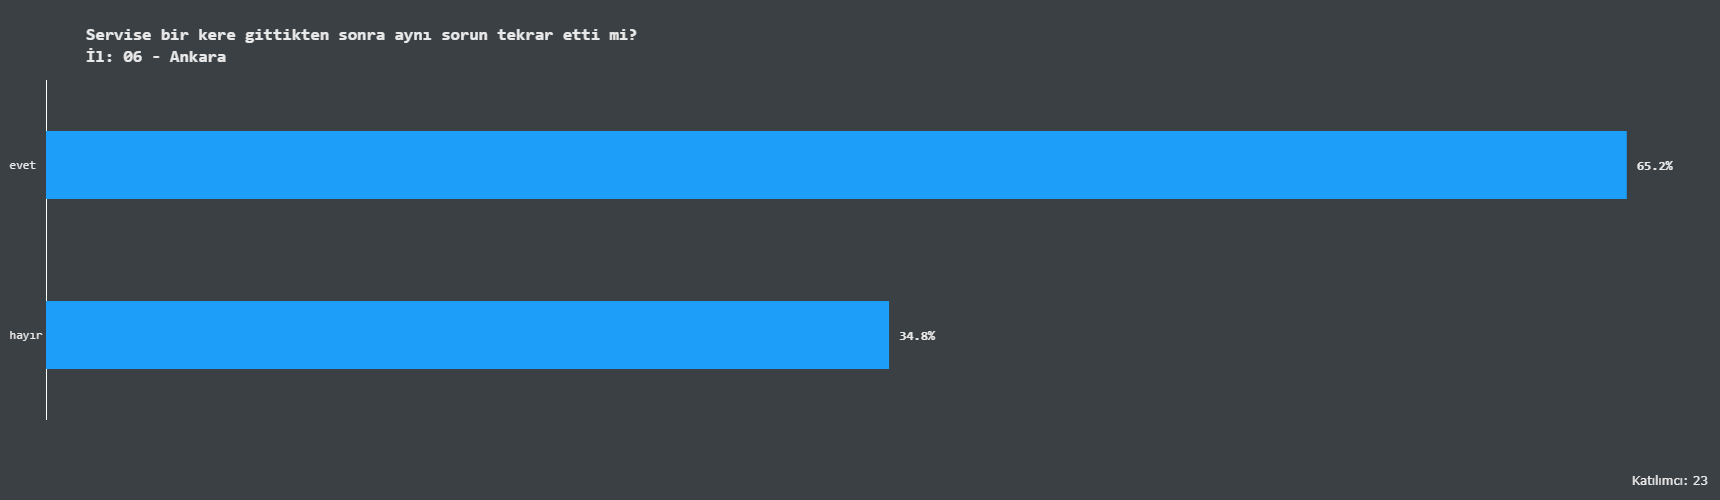

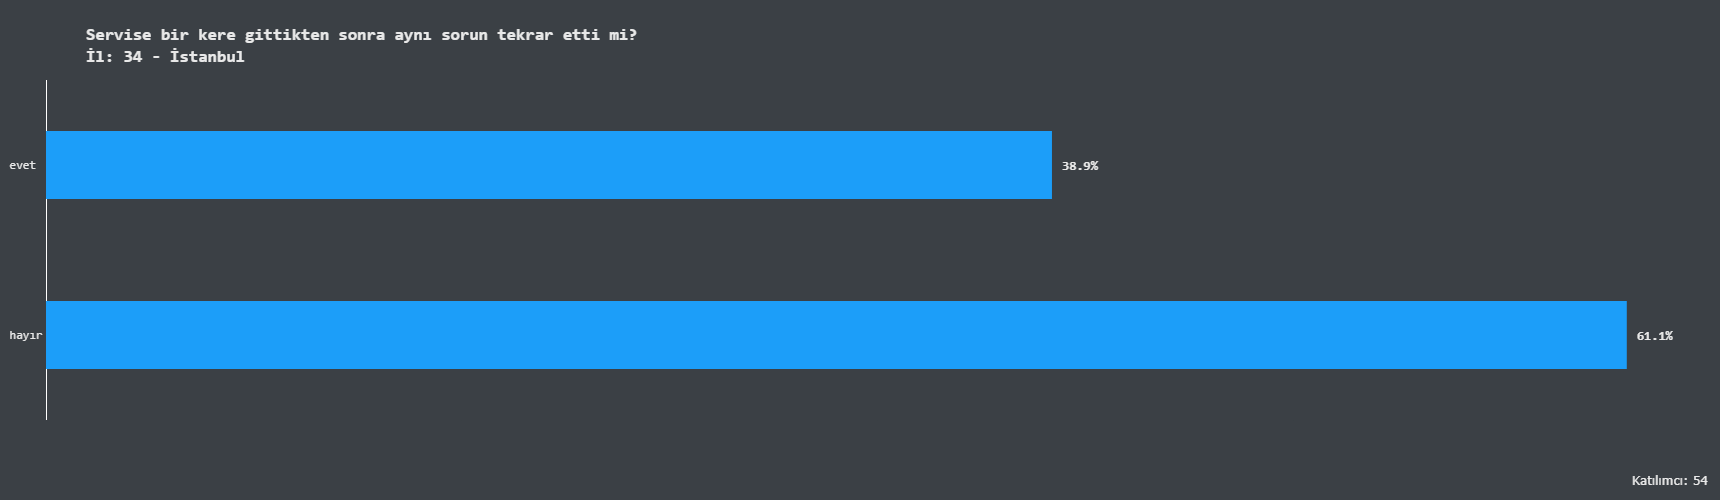

In [ ]:
for idx in range(34, 36):
    fig = make_chart(idx, sort_values=False, horizontal=False, rating=False)
    display(fig)
    fig = make_chart(idx, sort_values=False, horizontal=False, rating=False, filter={'İl': '06 - Ankara'})
    display(fig)
    fig = make_chart(idx, sort_values=False, horizontal=False, rating=False, filter={'İl': '34 - İstanbul'})
    display(fig)

## Sık Konuşulan Hatalar

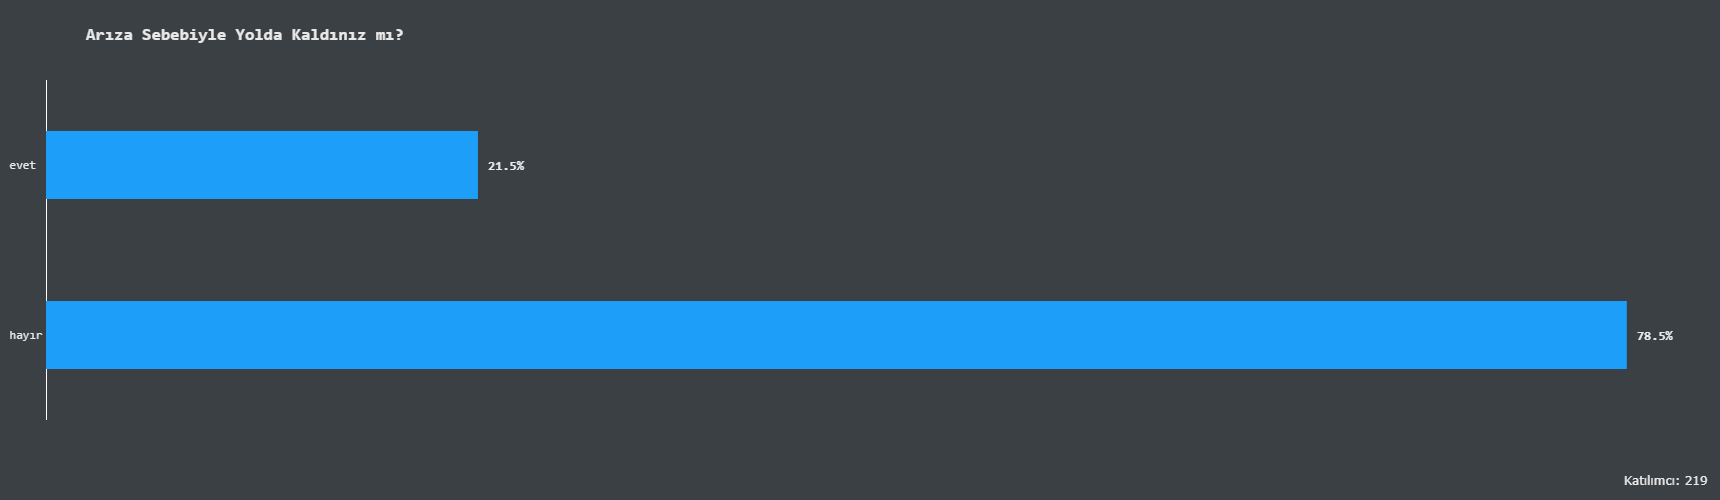

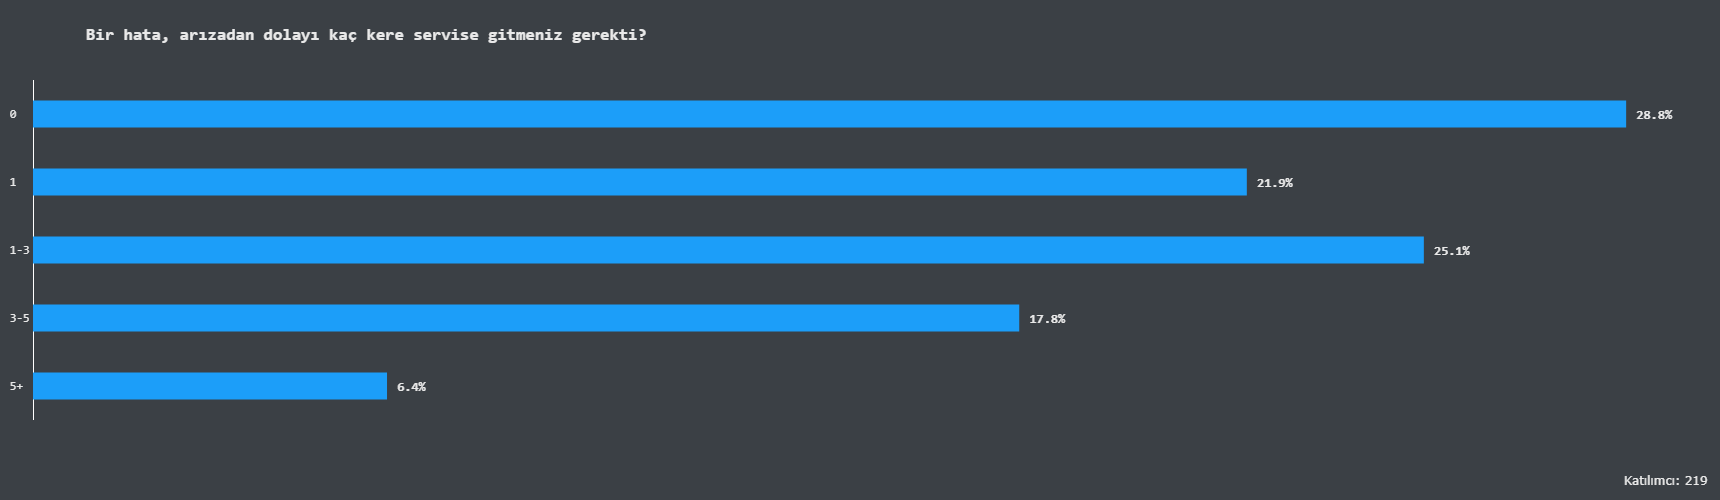

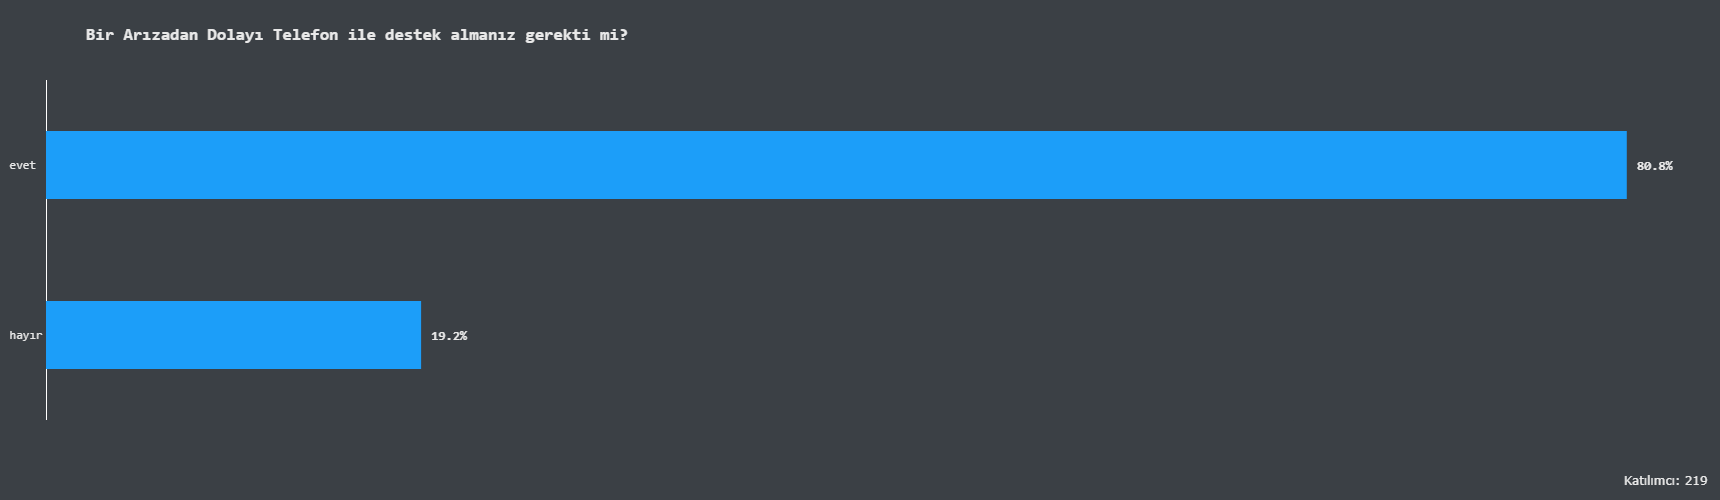

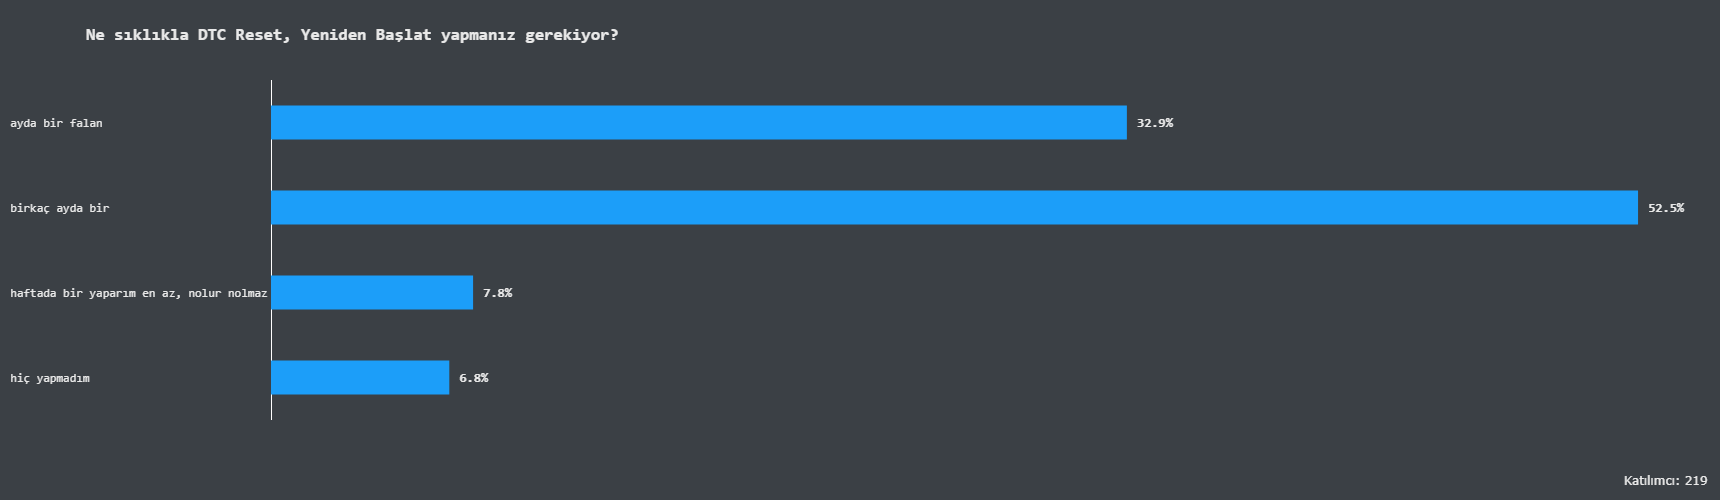

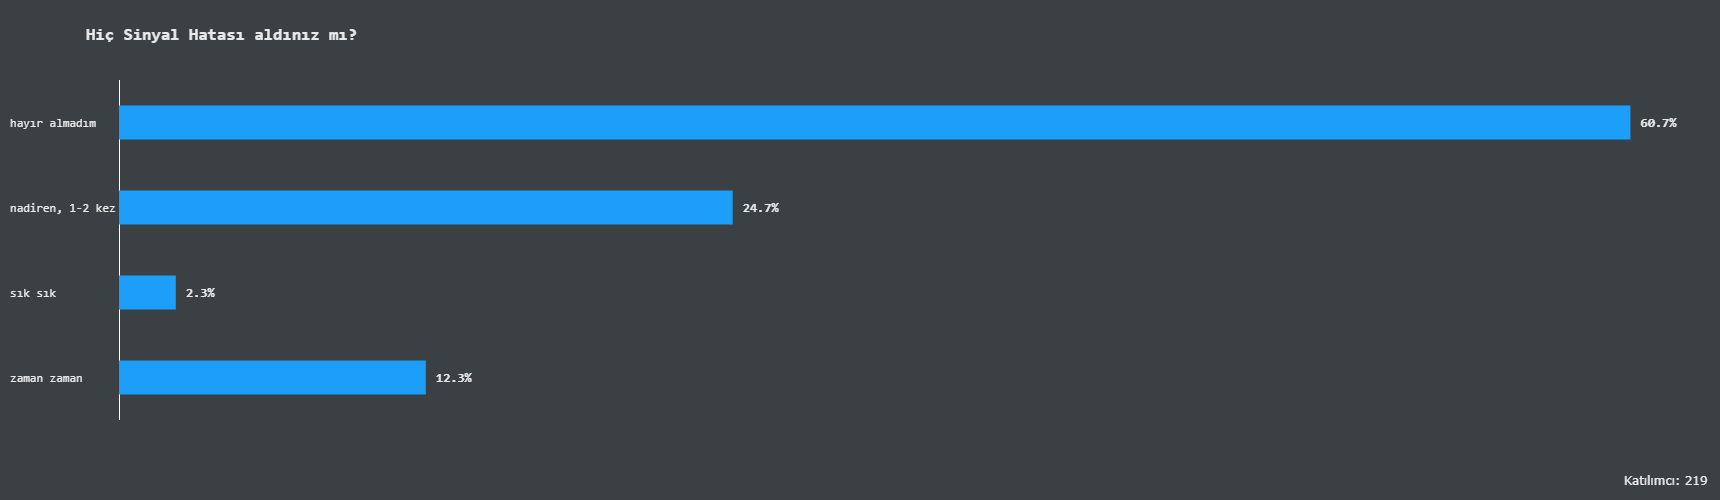

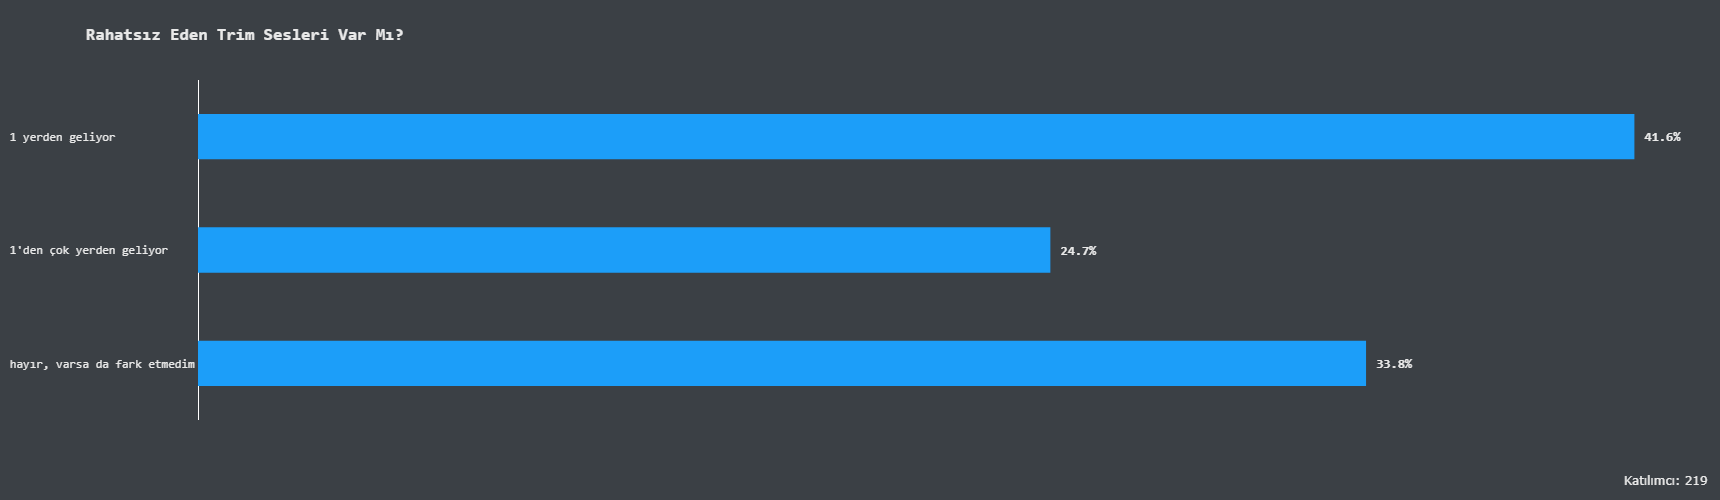

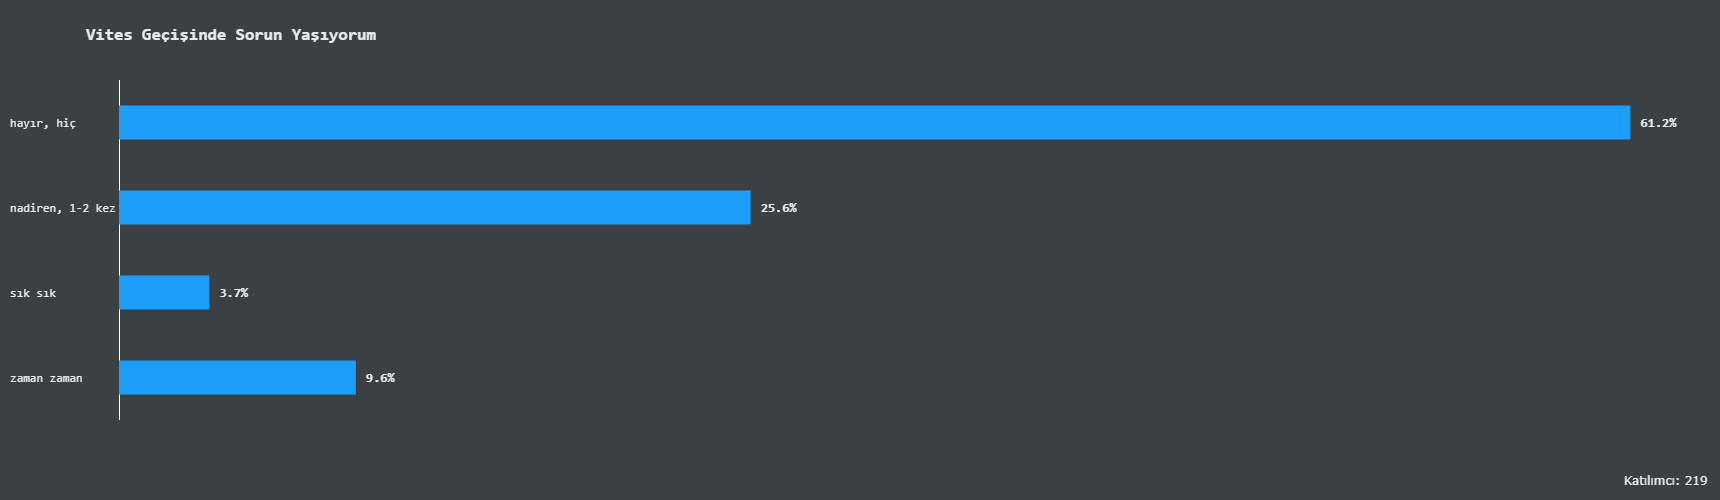

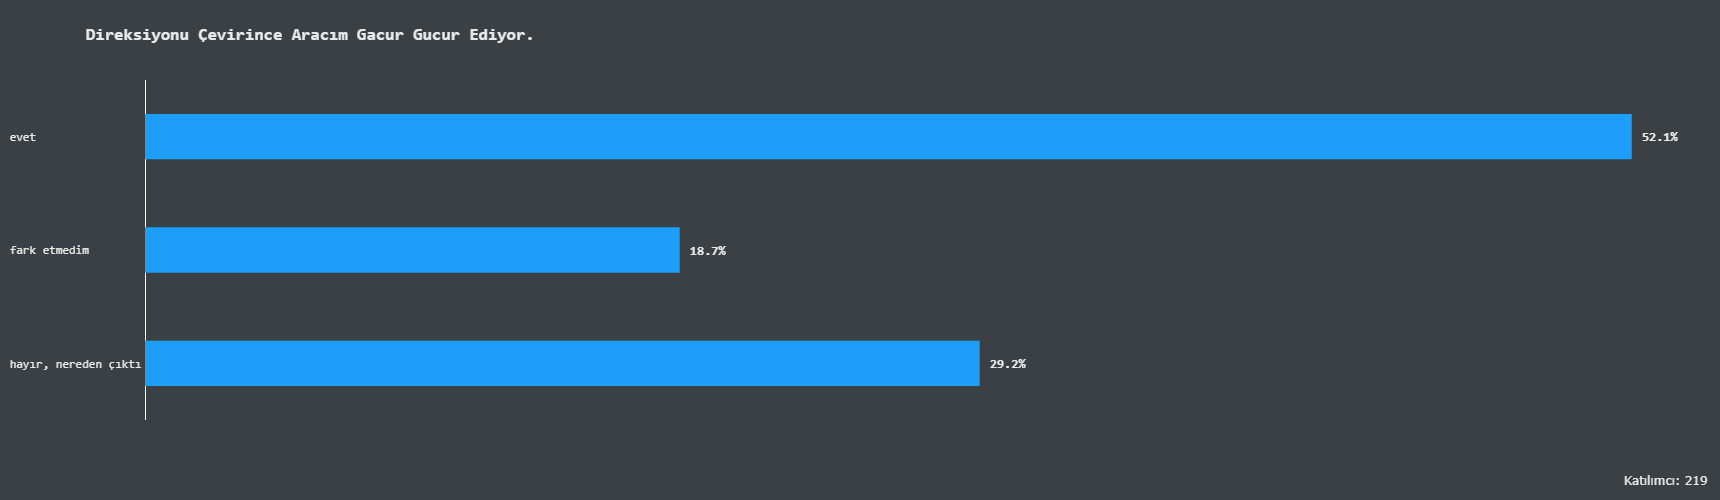

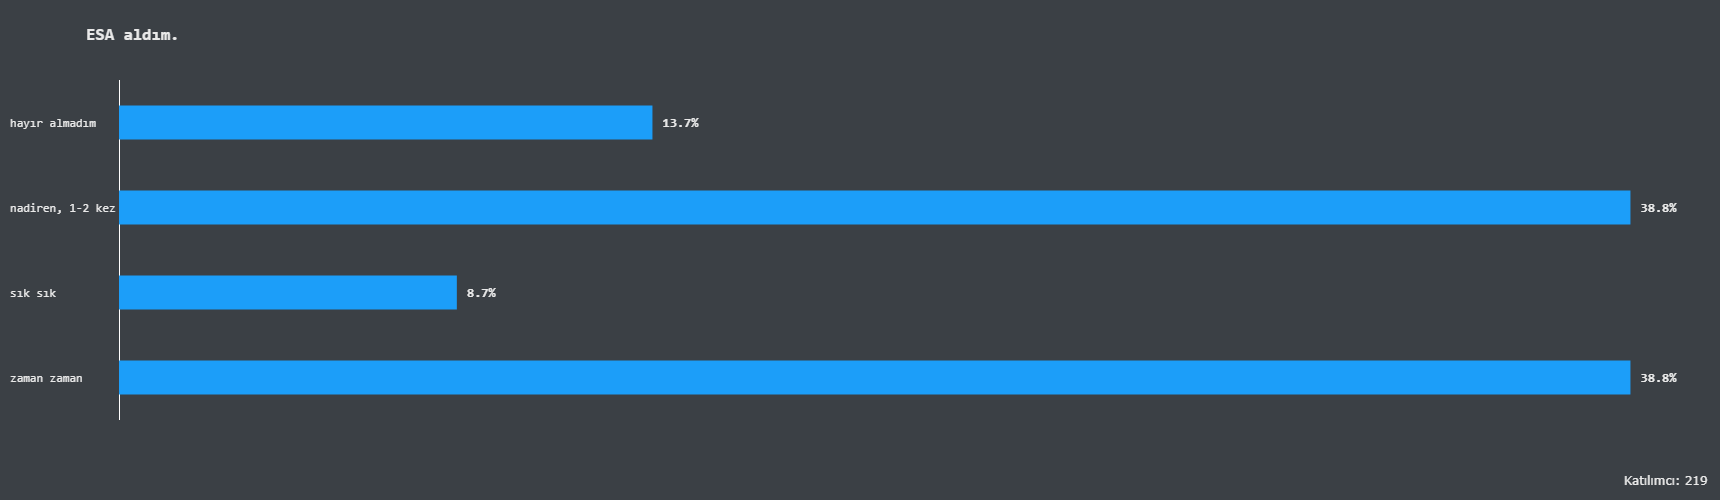

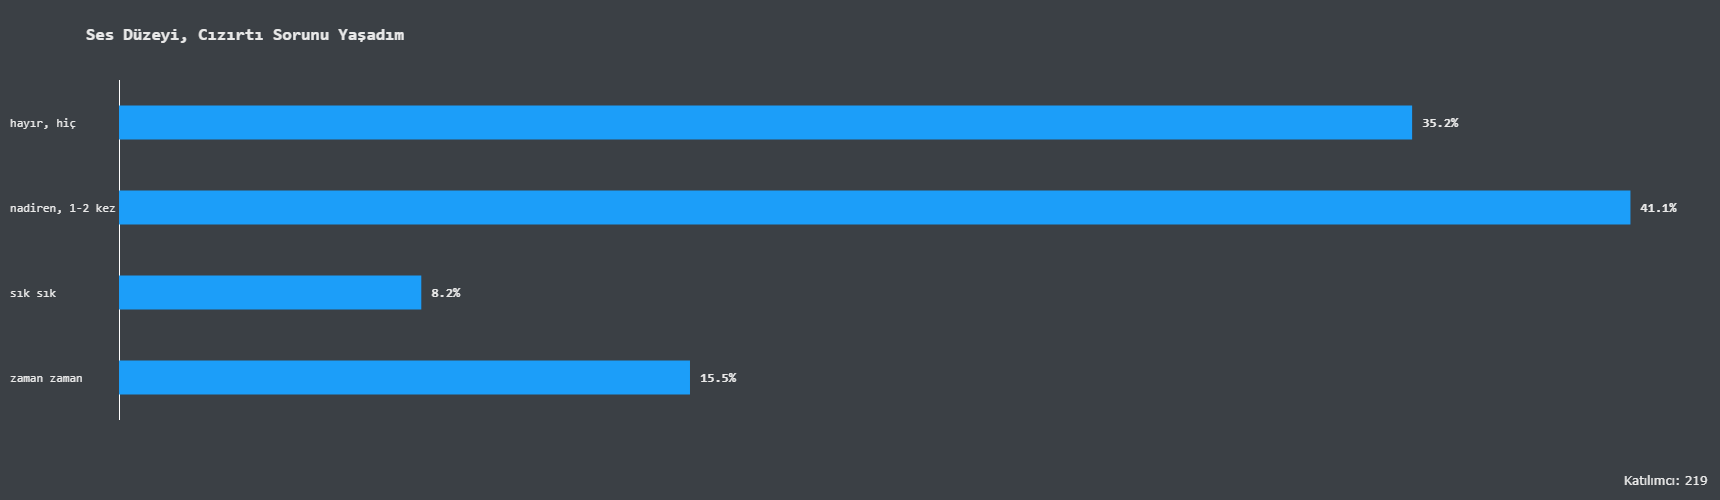

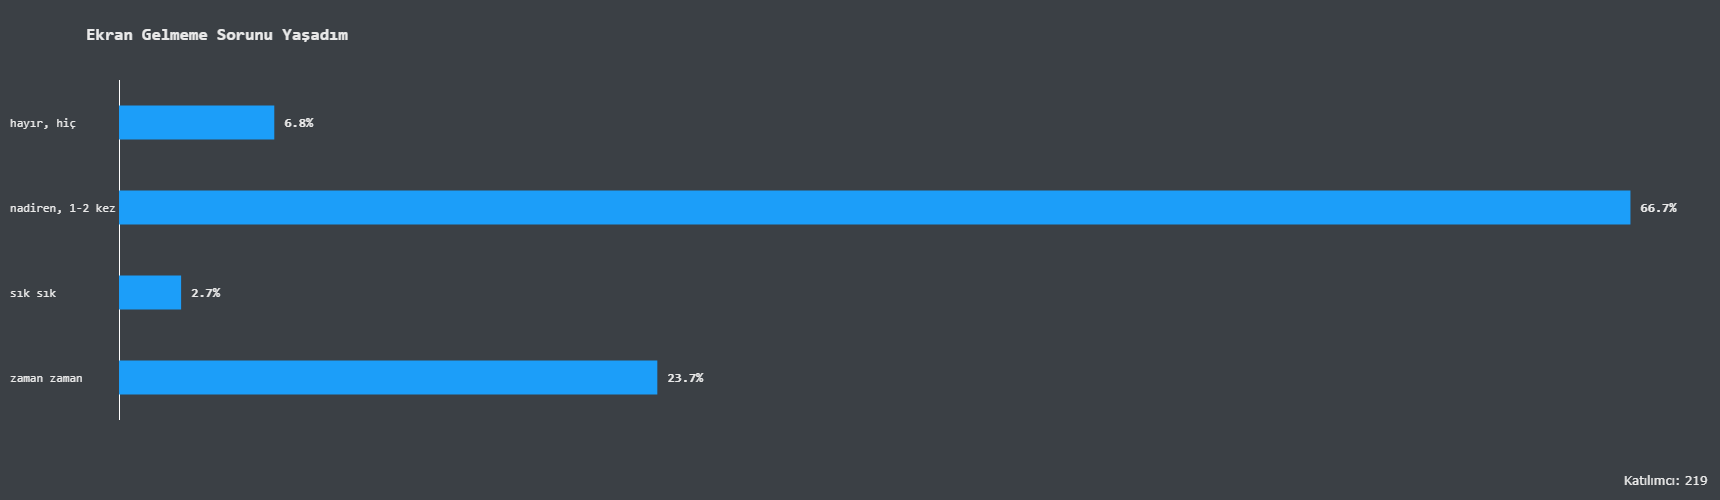

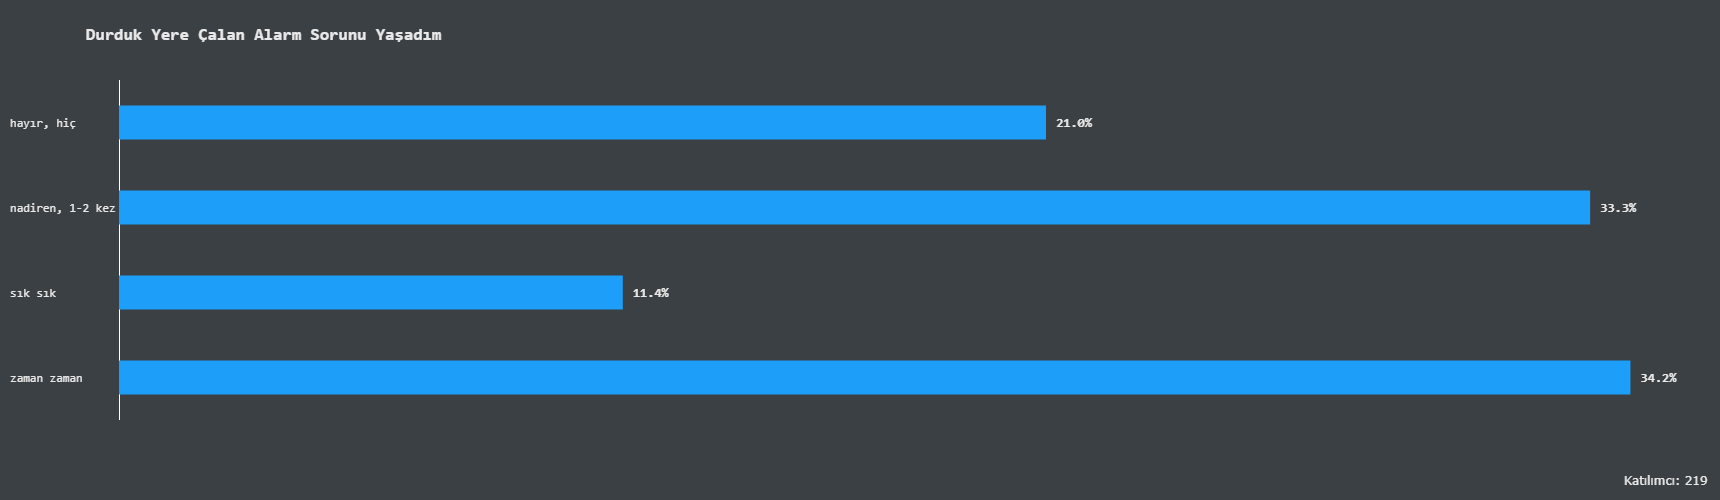

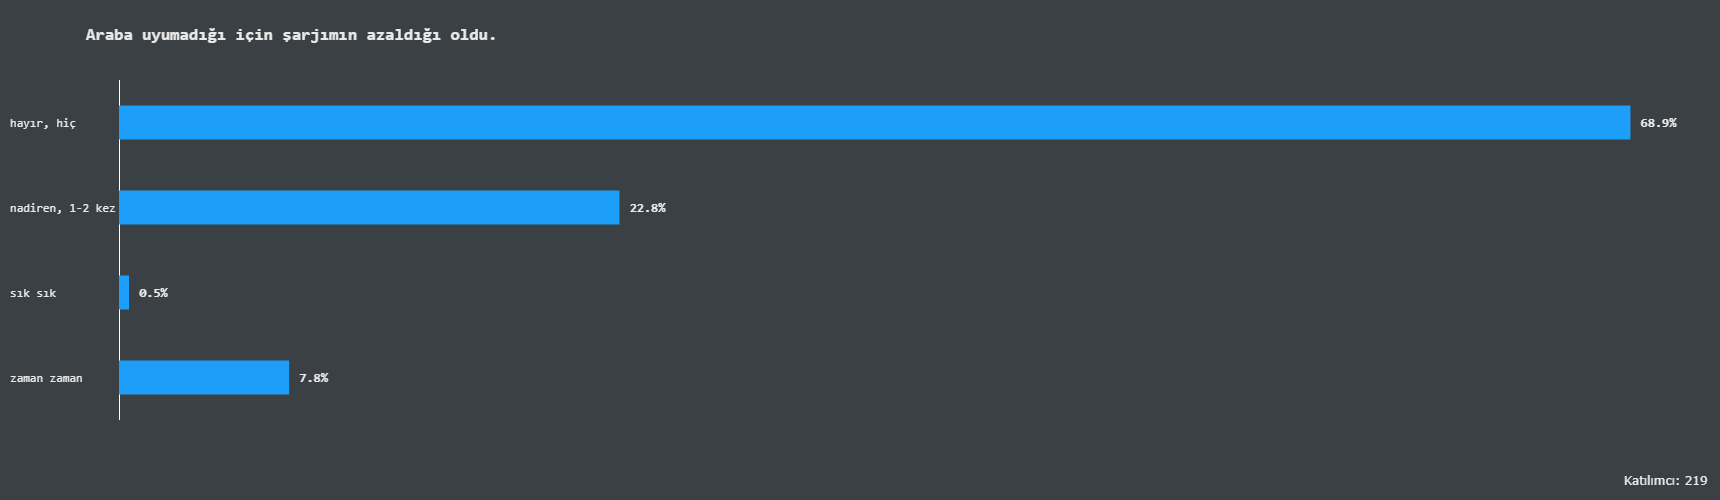

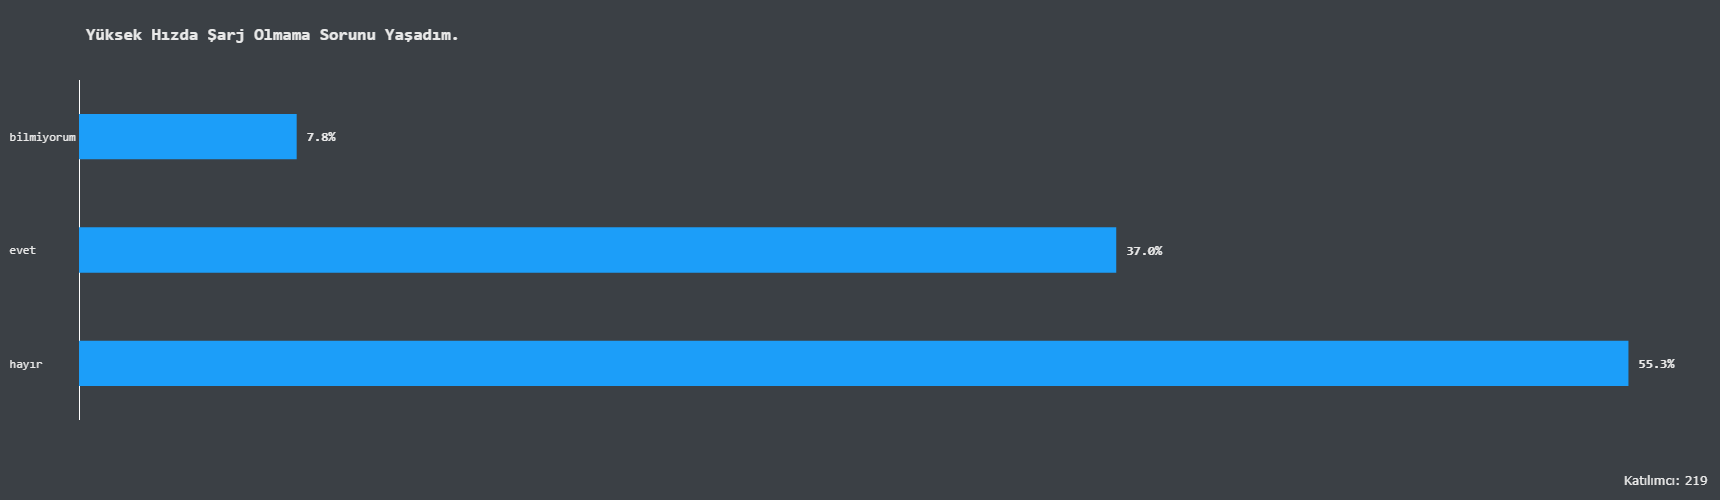

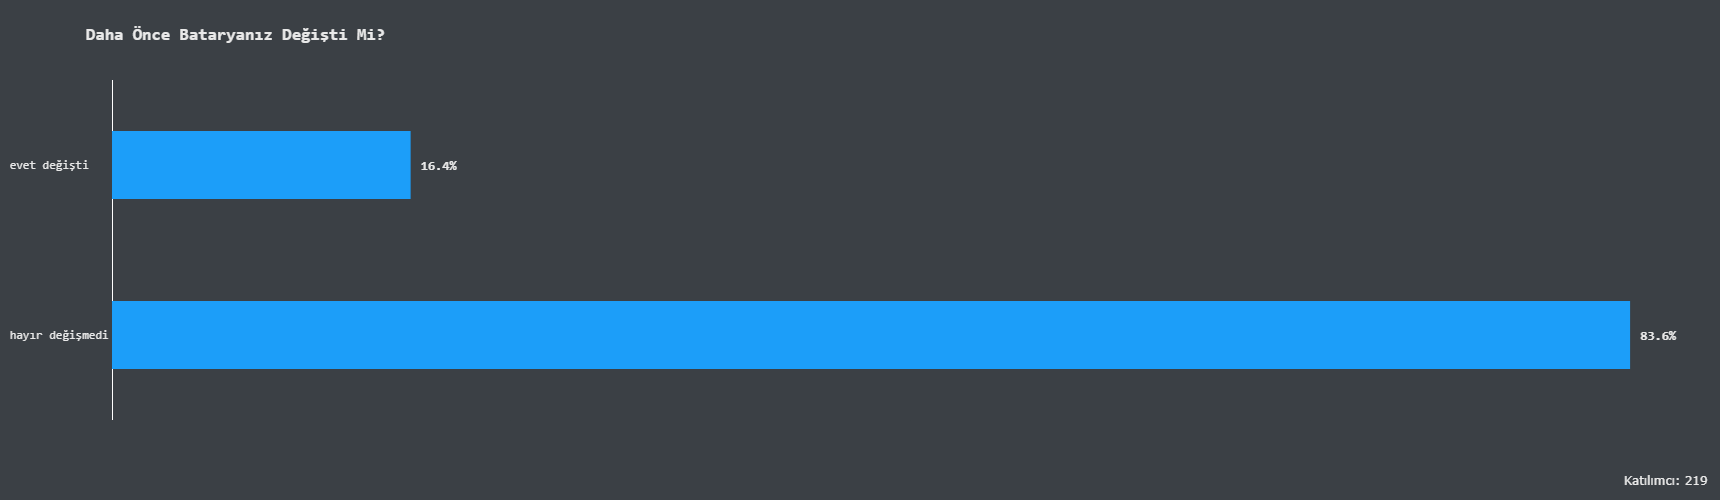

In [ ]:
for idx in range(32, 34):
    fig = make_chart(idx, sort_values=False, horizontal=False, rating=False)
    display(fig)

for idx in range(36, 49):
    fig = make_chart(idx, sort_values=False, horizontal=False, rating=False)
    display(fig)

## Açık Uçlu Sorular

In [ ]:
print(f'{data.columns[49]}:\n')
for idx in data.iloc[:, 49].dropna():
    print(idx)
    print('-'*40)

Belirtmek istediğiniz başka sorunlar yaşadıysanız, buyrun:

Bataryam değişmedi ancak değişim için randevu aldım. Büyük ihtimalle 2 hafta sonra değişecek. Çoğunlukla evden şarj ettiğim için şimdilik bir problem değil gibi olsada uzun yolda can sıkacak
----------------------------------------
Servis servis servis 
----------------------------------------
Güncellemeler yazılım hataları giderilsin
----------------------------------------
Şarj iyileştirme güncellemesi esnasında esa hatası ve birçok ikaz ışığı yakması akabinde Trumore veri akışı problemi.
----------------------------------------
Bu biraz benim uzun boylu olmamdan kaynaklanıyor.Ama aracın kör noktası çok fazla.
----------------------------------------
Park sensörü plakayı görüyor dediler sabitlediler ama ara ara önünde hiçbir engel yokken bile sensör aktif oluyor her hangi darbe çizik toz kir olmamasına rağmen 
----------------------------------------
Serviste bataryamın değişmesini talep ettim fakat servis bizim öyle bir uyg

In [ ]:
print(f'{data.columns[50]}:\n')
for idx in data.iloc[:, 50].dropna():
    print(idx)
    print('-'*40)

Varsa eklemek istediğiniz yazabilirsiniz.:

Yazılım ekibi berbat. Sadece araç değil web site, uygulama vs de kötü. Onlar düzelmeden bir daha asla almam.
----------------------------------------
Yine servis 
----------------------------------------
Sağlıcakla kalın.
----------------------------------------
Servisler ..... Neyse😏
----------------------------------------
Araçta sıkıntılar olmasına rağmen hiç servise gitmedim. Modül güncellemelerinin OTA'dan gelmesini bekliyorum inat ettim. Güncelleme için servise gitmeyeceğim. Diğer sıkıntılar için bakımı bekliyorum.
----------------------------------------
Umarım yetkililer de bu anketleri görür teşekkür ederim anket için 
----------------------------------------
Arabayı geçen ay ihtiyaçtan sattım lakin 0 alip 14 ay kullandığım için doldurmak istedim.
----------------------------------------
Arabanın değerini bitirdiler, tüm araçlar ikinci eli bile değer alırken bizi bitirdiler. Ben kullanıcıyım ancak bu kadar değer kaybetmesi normal değ